## Predicting House Prices: Regression Example

#### Boston House Pricing Dataset
Predict the median price of homes in a given Boston suburb in the mid-1970s, given data points about the suburb at the time, such as the crime rate, the local property tax rate, and so on. It has relatively few data points: only 506, split between 404 training samples and 102 test samples. And each feature in the input data (for example, the crime rate) has a different scale. For instance, some values are proportions, which take values between 0 and 1; others take values between 1 and 12, others
between 0 and 100, and so on.

### 1. Loading the dataset

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from keras import layers
from keras.datasets import boston_housing

In [2]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

40960/57026 [====================>.........] - ETA: 0s

In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

We have 404 training samples and 102 test samples, each with 13 numerical features

The targets are the median values of owner-occupied homes, in thousands of dollars: (The prices are typically between \$10,000 and \$50,000)

In [5]:
train_targets

array([ 15.2,  42.3,  50. ,  21.1,  17.7,  18.5,  11.3,  15.6,  15.6,
        14.4,  12.1,  17.9,  23.1,  19.9,  15.7,   8.8,  50. ,  22.5,
        24.1,  27.5,  10.9,  30.8,  32.9,  24. ,  18.5,  13.3,  22.9,
        34.7,  16.6,  17.5,  22.3,  16.1,  14.9,  23.1,  34.9,  25. ,
        13.9,  13.1,  20.4,  20. ,  15.2,  24.7,  22.2,  16.7,  12.7,
        15.6,  18.4,  21. ,  30.1,  15.1,  18.7,   9.6,  31.5,  24.8,
        19.1,  22. ,  14.5,  11. ,  32. ,  29.4,  20.3,  24.4,  14.6,
        19.5,  14.1,  14.3,  15.6,  10.5,   6.3,  19.3,  19.3,  13.4,
        36.4,  17.8,  13.5,  16.5,   8.3,  14.3,  16. ,  13.4,  28.6,
        43.5,  20.2,  22. ,  23. ,  20.7,  12.5,  48.5,  14.6,  13.4,
        23.7,  50. ,  21.7,  39.8,  38.7,  22.2,  34.9,  22.5,  31.1,
        28.7,  46. ,  41.7,  21. ,  26.6,  15. ,  24.4,  13.3,  21.2,
        11.7,  21.7,  19.4,  50. ,  22.8,  19.7,  24.7,  36.2,  14.2,
        18.9,  18.3,  20.6,  24.6,  18.2,   8.7,  44. ,  10.4,  13.2,
        21.2,  37. ,

### 2. Data Preparation
It would be problematic to feed into a neural network values that all take wildly different ranges. The network might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. A widespread best practice to deal with such data is to do feature-wise normalization: for each feature in the input data (a column in the input data matrix), you subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has a unit standard deviation.

In [6]:
# Compute train mean
mean = train_data.mean(axis=0)

# Compute train std dev
std = train_data.std(axis=0)

# Normalize train data
train_data -= mean
train_data /= std

In [7]:
# Normalize test data
test_data -= mean
test_data /= std

**Note:** The quantities used for normalizing the test data are computed using the training data. You should never use in your workflow any quantity computed on the test data, even for something as simple as data normalization.

### 3. Building the network
Because so few samples are available, you’ll use a very small network with two hidden layers, each with 64 units. In general, the less training data you have, the worse overfitting will be, and using a small network is one way to mitigate overfitting.

Since we sometimes need to instantiate the same model multiple times, lets  use a function to construct it.

In [9]:
def build_model():
    # Initialize the model
    model = models.Sequential()
    
    # Hidden layer 1 => 64 units
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    
    # Hidden layer 2 => 64 units
    model.add(layers.Dense(64, activation='relu'))
    
    # Output layer with no activation (equivalent to identity activation => for regression problems)
    model.add(layers.Dense(1))
    
    # Compile the model (Note the loss function and metric)
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    # return the compiled model
    return model

### 4. Validating using K-fold validation
To evaluate your network while you keep adjusting its parameters (such as the number of epochs used for training), you could split the data into a training set and a validation set, as you did in the previous examples. But because you have so few data points, the validation set would end up being very small (for instance, about 100 examples). As a consequence, the validation scores might change a lot depending on which data points you chose to use for validation and which you chose for training: the validation scores might have a **high variance** (overfitting) with regard to the validation split. This would prevent you from reliably evaluating your model.

The best practice in such situations is to use K-fold cross-validation. It consists of splitting the available data into K partitions (typically K = 4 or 5), instantiating K identical models, and training each one on K – 1 partitions while evaluating on the remaining partition. The validation score for the model used is then the average of the K validation scores obtained. In terms of code, this is straightforward.

In [77]:
k = 4 # 4-fold CV
num_val_samples = len(train_data) // k # Comput size of each fold
num_epochs = 100 # Run 100 epochs
all_scores = [] # Records the scores for all the k iterations

In [78]:
for i in range(k):
    print('processing fold #', i)
    
    # Prepare the validation data: data from partition 'i'
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                         train_data[(i + 1) * num_val_samples:]],
                                        axis=0)
    
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                            train_targets[(i + 1) * num_val_samples:]],
                                           axis=0)
    
    # Builds the Keras model (already compiled)
    model = build_model()
    
    # Train the model (in silent mode, verbose = 0)
    # Note: batch_size = 1, executing pure SGD
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
    
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    
    # Append the scores for the current iteration
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


Running this with num_epochs = 100 yields the following results:

In [79]:
all_scores

[2.1135453115595451,
 2.5072592933579245,
 2.7487937518865757,
 2.4034708797341526]

In [80]:
np.mean(all_scores)

2.4432673091345496

The different runs do indeed show rather different validation scores, from 2.11 to 2.75. The average (2.44) is a much more reliable metric than any single score — that’s the entire point of K-fold cross-validation. In this case, you’re off by \$2,440 on average.

Let’s try training the network a bit longer: **500 epochs**. To keep a record of how well the model does at each epoch, we’ll modify the training loop to save the perepoch validation score log.

This may take about an hour

In [14]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    
    # Prepare the validation data: data from partition 'i'
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], \
                                         train_data[(i + 1) * num_val_samples:]],
                                        axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                            train_targets[(i + 1) * num_val_samples:]],
                                           axis=0)
    
    # Builds the Keras model (already compiled)
    model = build_model()
    
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data,
                        partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs,
                        batch_size=1,
                        verbose=0)
    
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [15]:
# The dictionary contains following fields
history.history.keys()

dict_keys(['val_loss', 'loss', 'mean_absolute_error', 'val_mean_absolute_error'])

"all_mae_histories" is a list of lists => It conatins 4 outer lists corresponding to each fold and each of these 4 lists contains 500 mae scores corresponding to 500 epochs of that fold as follows (each column below is a list):

![title](mae.jpg)

In [17]:
len(all_mae_histories)

4

In [18]:
len(all_mae_histories[0])

500

#### Building the history of successive mean K-fold validation scores
The below code takes the average mae score for a particular epoch in each of the 4-folds. **Basically it is averaging the rows in the above table.**

In [19]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

In [27]:
## Contains 500 scores(for each epoch) averaged over the 4 folds
len(average_mae_history)

500

In [81]:
np.mean(average_mae_history)

2.6613945203512022

#### Plotting validation scores

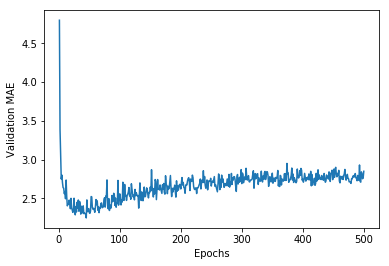

In [22]:
# Range epochs from 1 to 500 instead of 0 to 499
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

It may be a little difficult to see the plot, due to scaling issues and relatively high variance.

Let’s do the following:
* Omit the first 10 data points, which are on a different scale than the rest of the curve.
* Replace each point with an exponential moving average of the previous points, to obtain a smooth curve.

#### Plotting validation scores, excluding the first 10 data points

In [30]:
def smooth_curve(points, factor=0.9):
    '''
    Create a smooth curve by taking exponentially weigthed averages with a factor of 0.9
    This is as good as taking an average over the previous 10 values in the series
    '''
    smoothed_points = []
    for point in points:
        if smoothed_points: # smoothed_points contains at least one value
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else: # Boundary case for the first value
            smoothed_points.append(point)
    return smoothed_points

In [31]:
# Pass all the scores, except first 10
smooth_mae_history = smooth_curve(average_mae_history[10:])

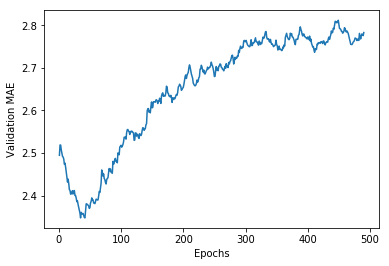

In [33]:
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

According to this plot, validation MAE stops improving significantly after 40 epochs. Past that point, you start overfitting.

#### Training the final model with 40 epochs

In [74]:
# Get a fresh, compiled model
model = build_model()

# Train it on the entirety of the data
# Using batch_size=16
model.fit(train_data, train_targets, epochs=40, batch_size=4, verbose=0)

In [75]:
# Evaluate on the test data
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

 32/102 [========>.....................] - ETA: 1s

In [76]:
# Final score
test_mae_score

2.6481952199748919

On the test set, we are off by about off $2,650